In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import torch
import torch.optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.linalg import circulant

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


In [2]:
def getX(d=5,n=10):
    x = np.random.randn(n)/np.sqrt(n)
    x = x - np.mean(x)
    X = circulant(x)
    for i in range(d-1):
        Wk = circulant(np.random.randn(n)/np.sqrt(n))
        X = np.dot( X , Wk )
    return X

def getGrad(X,y,w):
    return np.dot(X.T, y - np.dot(X,w) )

def getNGrad(X,y,w):
    Xw = np.dot(X,w)
    nor = np.linalg.norm(Xw)
    n = len(X)
    return np.dot(X.T , np.dot( (np.eye(n) - np.dot(Xw, Xw.T)/nor**2) , y)) / nor

## Distribution of gradient norms with and without normalization

In [3]:
def simulate(fun,n = 10,d = 6,numit = 1000):
    res = []
    for i in range(numit):
        X = getX(d=d,n=n)
        y = np.random.randn(n)
        w = np.random.randn(n)
        #print( np.linalg.norm(y)/np.linalg.norm( np.dot(X,w) ) )
        res += [np.linalg.norm(fun(X,y,w))]
    return res

In [4]:
def tikz_hist(res,bins=100,filename="data.csv"):
    hist = plt.hist(res,normed=True, bins=bins)
    plt.show()
    x = np.array([ (hist[1][i] + hist[1][i+1])/2 for i in range(bins) ])
    y = np.array(hist[0])
    np.savetxt(filename, np.vstack([ x , y ]).T , delimiter="\t")

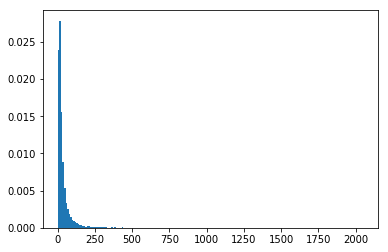

In [43]:
res = simulate(fun=getGrad,n=100,d=6,numit=20000)
tikz_hist(res,bins=200,filename="hist_nonorm.data")

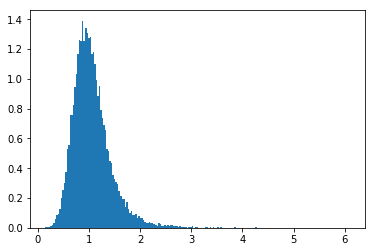

In [44]:
res = simulate(fun=getNGrad,n=100,d=6,numit=20000)
tikz_hist(res,bins=200,filename="hist_norm.data")

## Distribution of gradient norms for multi-channel CNN

In [21]:
def init_normal(m):
    if type(m) == nn.Conv1d:
        nn.init.normal_(m.weight,0,np.sqrt(1/64))

def grad_eval(net, y, net_input, LR = 0.05):
    p = [x for x in net.parameters()]
    # optimizer = torch.optim.SGD(p, lr=LR,momentum=0)
    mse = torch.nn.MSELoss()

    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1

    out = net(net_input.type(dtype))

    # training loss 
    loss = mse(out, y)
    loss.backward()
    mse_wrt_noisy = loss.data.cpu().numpy()

    # output gradients
    out_grads = np.zeros(nconvnets)
    for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
        # print(p.shape)
        out_grads[ind] = p.grad.data.norm(2).item()**2

    overall_grads = np.sqrt(sum(out_grads))
    return overall_grads 

def tikz_hist(res,bins=100,filename="data.csv"):
    hist = plt.hist(res,normed=True, bins=bins)
    plt.show()
    x = np.array([ (hist[1][i] + hist[1][i+1])/2 for i in range(bins) ])
    y = np.array(hist[0])
    np.savetxt(filename, np.vstack([ x , y ]).T , delimiter="\t")
    

In [10]:
def pad_circular1d(x, pad):
    x = torch.cat([x, x[0:pad]])
    x = torch.cat([x[-2 * pad:-pad], x])
    return x

class Pad1d(torch.nn.Module):
    def __init__(self, pad):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Pad1d, self).__init__()
        self.pad = pad
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        shape = [1,x.shape[1],x.shape[2]+2*self.pad]
        xx = Variable(torch.zeros(shape)).type(dtype)
        for i in range(x.shape[1]):
            xx[0,i] = pad_circular1d(x[0,i],self.pad)
        return xx # pad_circular1d(x, self.pad)



class ChannelNormalization(torch.nn.Module):
    '''
    Different ways to normalize the channels
    '''
    def __init__(self, D_in,mode="BN"):
        self.mode = mode
        super(ChannelNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(D_in))
        self.beta = nn.Parameter(torch.zeros(D_in))
        
    def forward(self, x):
        xx = Variable(torch.zeros(x.shape)).type(dtype)
        for i,(g,b) in enumerate(zip(self.gamma,self.beta)):
            #print(i, x[0][i].shape)
            if self.mode == "BN":
                #xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) * g  + b
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "mult":
                xx[:,i] = x[:,i]*g + b
            elif self.mode == "non-learned":
                xx[0][i] = (x[0][i] - torch.mean(x[0][i]))/torch.sqrt( torch.var(x[0][i]) + 0.00001 )
            elif self.mode == "center":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))
            elif self.mode == "normalize":
                xx[0][i] = (x[0][i])/torch.sqrt( torch.var(x[0][i]) )
            elif self.mode == "only+bias":
                xx[:,i] = x[:,i] + b
            elif self.mode == "onlycenter+bias":
                xx[:,i] = (x[:,i] - torch.mean(x[:,i]))*g + b
            elif self.mode == "almostcenter":
                xx[:,i] = ( (x[:,i] - torch.mean(x[:,i])) + torch.mean(x[:,i]) / torch.from_numpy( np.sqrt( np.array([np.prod(x[0][i].shape)]) ) ).float().type(dtype)) /torch.sqrt( torch.var(x[0][i]) + 0.00001 ) + b
            elif self.mode == "center+scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / (torch.max( torch.abs(x[:,i] - torch.mean(x[:,i]) ) ) + 0.00001)
            elif self.mode == "center+mean_scale":
                xx[:,i] =  (x[:,i] - torch.mean(x[:,i])) / torch.mean(torch.abs( x[:,i] - torch.mean(x[:,i]) ) )
            elif self.mode == "scale":
                z =  x[0][i]
                xx[0][i] = z / ( torch.norm(z) + 0.00001 )*g + b
            elif self.mode == "linear":
                xx = x
            else:
                raise ValueError('not an option for channel normalization.')
        return xx
    
    
def conv(in_f, out_f, kernel_size, stride=1,bias=False,pad=True):
    '''
    Circular convolution
    '''
    to_pad = int((kernel_size - 1) / 2)
    if pad:
        padder = Pad1d(to_pad)
    else:
        padder = None

    #convolver = nn.utils.weight_norm(nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias), name='weight')
    convolver = nn.Conv1d(in_f, out_f, kernel_size, stride, padding=0, bias=bias)
    
    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers).type(dtype)



class ResidualBlock(nn.Module):
    def __init__(self, in_f, out_f, kernel_size, stride=1,bias=False,pad=True,mode="BN"):
        super(ResidualBlock, self).__init__()
        self.conv = conv(in_f, out_f, kernel_size, stride=stride,bias=bias,pad=pad)
        self.norm = ChannelNormalization(in_f,mode=mode)
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = self.norm(out)
        out += residual
        return out

def decnet(
        num_output_channels=1, 
        num_channels_up=[1]*5, 
        filter_size_up=2,
        act_fun=nn.ReLU(), # nn.LeakyReLU(0.2, inplace=True) 
        mode = "BN",
        modeout = "none",
        res = True,
        ):
    
    num_channels_up = num_channels_up + [num_channels_up[-1]]
    n_scales = len(num_channels_up) 
    
    model = nn.Sequential()

    for i in range(len(num_channels_up)-1):
        if res:
            model.add(ResidualBlock( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1,mode))
        else:

            model.add(conv( num_channels_up[i], num_channels_up[i+1],  filter_size_up, 1))
            if act_fun != None:
                model.add(act_fun)
            model.add(ChannelNormalization(num_channels_up[i],mode=mode))
            #model.add( nn.BatchNorm1d( num_channels_up[i] ,affine=True) )

            
    if modeout != "none":
        model.add(ChannelNormalization(num_channels_up[i+1],mode=modeout))
        #model.add( nn.BatchNorm1d( num_channels_up[i+1] ,affine=True) )
    model.add(conv(num_channels_up[-1], num_output_channels, 1, bias=True,pad=False))
    # model.add(nn.Sigmoid())
    
    return model



def fit(net,
        y,
        num_channels,
        net_input = None,
        num_iter = 5000,
        LR = 0.01,
       ):

    if net_input is not None:
        print("input provided")
    else:
        length = int(y.data.shape[2])
        shape = [1,num_channels[0], length ]
        print("input shape: ", shape)
        net_input = Variable(torch.ones(shape)).type(dtype)
        net_input.data.uniform_()
        
    
    net_input = net_input.type(dtype)
    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
     
    print("optimize with SGD", LR)
    optimizer = torch.optim.SGD(p, lr=LR,momentum=0)
    
    mse = torch.nn.MSELoss() #.type(dtype) 
   
    nconvnets = 0
    for p in list(filter(lambda p: len(p.data.shape)>2, net.parameters())):
        nconvnets += 1
    
    out_grads = np.zeros((nconvnets,num_iter))
    out_filters = np.zeros((nconvnets+1,num_iter))
    init_para = np.zeros((9,nconvnets+1))
    for i in range(num_iter):
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))

            # training loss 
            loss = mse(out, y)
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
            
            # output gradients
            for ind,p in enumerate(list(filter(lambda p: p.grad is not None and len(p.data.shape)>2, net.parameters()))):
                out_grads[ind,i] = p.grad.data.norm(2).item()
            
            # output norms of filters
            ind = 0
            for m in net.modules():
                if isinstance(m, nn.Conv1d):
                    out_filters[ind,i] = m.weight.data.norm(2).item()
                    if i == 0:
                        init_para[:,ind] = m.weight.data.numpy()[0,0]
                    ind += 1
                    #print(m.weight.data.cpu().numpy()) 
        
                   
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f' % (i, loss.data), '\r', end='')
            
            return loss   
        
        loss = optimizer.step(closure)
                  
    return mse_wrt_noisy, net_input, net, out_grads, out_filters

### Generate Signals

In [12]:
n = 256

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep = np_to_var(ystep_np).type(dtype)
ystep_np = ystep_np[0]
print(ystep.shape)

# shape = [1,4,n]
# print("input shape: ", shape)
# net_input = Variable(torch.ones(shape)).type(dtype)
# net_input.data.uniform_()

torch.Size([1, 1, 256])


### num_channels =  4, network depth = 6, with channel normalization

In [26]:
num_channels = [4]*6

num_iter = 2000
para_grad_linear = np.zeros(num_iter)

for i in range(num_iter):
    shape = [1,4,n]
    net_input = Variable(torch.ones(shape)).type(dtype)
    net_input.data.uniform_()
    net_input = net_input.type(dtype)

    net = decnet(1,num_channels,9,act_fun=nn.ReLU(),mode="non-learned",res=False).type(dtype)
    net.apply(init_normal)

    para_grad_linear[i] = grad_eval(net, y=ystep, net_input=net_input)

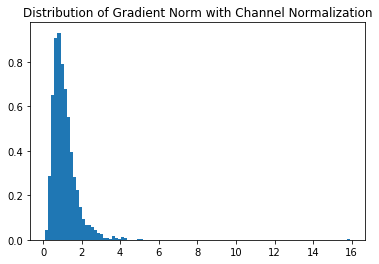

In [27]:
plt.hist(para_grad_linear, normed=True, bins=100)
plt.title('Distribution of Gradient Norm with Channel Normalization')
plt.show()

### num_channels =  4, network depth = 6, without normalization

In [28]:
num_channels = [4]*6

num_iter = 2000
para_grad_linear = np.zeros(num_iter)

for i in range(num_iter):
    shape = [1,4,n]
    net_input = Variable(torch.ones(shape)).type(dtype)
    net_input.data.uniform_()
    net_input = net_input.type(dtype)

    net = decnet(1,num_channels,9,act_fun=nn.ReLU(),mode="linear",res=False).type(dtype)
    net.apply(init_normal)

    para_grad_linear[i] = grad_eval(net, y=ystep, net_input=net_input)

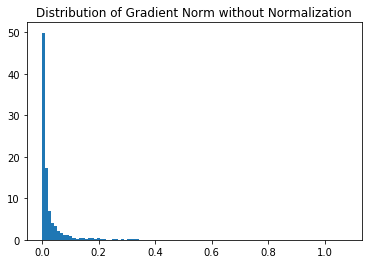

In [29]:
plt.hist(para_grad_linear, normed=True, bins=100)
plt.title('Distribution of Gradient Norm without Normalization')
plt.show()